In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.spatial.transform import Rotation as R
import time
import pickle
import argparse 
from utils import *
import copy
from deepVCP_loss import get_rigid_transform

from deepVCP import DeepVCP
from ModelNet40Dataset import ModelNet40Dataset
from KITTIDataset import KITTIDataset
from deepVCP_loss import deepVCP_loss

import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
  

In [2]:


# check if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

batch_size=1
# dataset 

root = 'modelnet40_normal_resampled/'
shape_names = np.loadtxt(root+"modelnet10_shape_names.txt", dtype="str")
test_data = ModelNet40Dataset(root=root, augment=True, full_dataset=True,  split='test')
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

num_test = len(test_data)
print('Test dataset size: ', num_test)


device: cuda
# Total clouds 1
Test dataset size:  1


In [3]:
model = DeepVCP(use_normal=True)

In [4]:
model.load_state_dict(torch.load('epoch_2_model.pt'))

<All keys matched successfully>

In [5]:
model.to(device)

DeepVCP(
  (FE1): feat_extraction_layer(
    (sa1): PointNetSetAbstraction(
      (mlp_convs): ModuleList(
        (0): Conv2d(6, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (mlp_bns): ModuleList(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (sa2): PointNetSetAbstraction(
      (mlp_convs): ModuleList(
        (0): Conv2d(6, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (mlp_bns): ModuleList(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [6]:
# begin test 
model.eval()
loss_test = []
rot_error = []
translation_error = []
with torch.no_grad():
    for n_batch, (src, target, R_gt, t_gt, R_prior) in enumerate(test_loader):
        # mini batch
        src, target, R_gt, t_gt, R_prior = src.to(device), target.to(device), R_gt.to(device), t_gt.to(device), R_prior.to(device)
        t_init = torch.zeros(1, 3)
        src_keypts, target_vcp = model(src, target, R_prior, t_init)

        loss, R_pred, t_pred = deepVCP_loss(src_keypts, target_vcp, R_gt, t_gt, alpha=0.5)
        # error metric for rigid body transformation
        r_pred = R.from_matrix(R_pred.squeeze(0).cpu().detach().numpy())
        r_pred_arr = torch.tensor(r_pred.as_euler('xyz', degrees=True)).reshape(1, 3)
        r_gt = R.from_matrix(R_gt.squeeze(0).cpu().detach().numpy())
        r_gt_arr = torch.tensor(r_gt.as_euler('xyz', degrees=True)).reshape(1, 3)
        pdist = nn.PairwiseDistance(p = 2)
        rot_error.append(pdist(r_pred_arr, r_gt_arr).item())
        translation_error.append(pdist(t_pred[:,:,0], t_gt[:,:,0]).item())
        
        print("rotation error test: ", rot_error[-1])
        print("translation error test: ", translation_error[-1])

        loss_test += [loss.item()]

with open("test_loss.txt", "wb") as fp_test:   #Pickling
    pickle.dump(loss_test, fp_test)
print("Test loss:", loss)

Processing file: person_0087.txt
feature extraction time:  9.081605672836304
src_keypts_idx_unsqueezed:  torch.Size([1, 6, 64])
src_keypts:  torch.Size([1, 64, 6])
Grouping keypoints time:  0.024999380111694336
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0


c:\Users\niladutt\.conda\envs\nsd2\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([2648,  769, 3419,  ..., 8551, 3543, 1157], device='cuda:0')
get_cat_feat_tgt time:  0.0950007438659668
Loss: 0.11314318797489263
rotation error test:  18.615457746074366
translation error test:  0.3081152448855634
Test loss: tensor(0.1131, device='cuda:0', dtype=torch.float64)


In [7]:
R_pred, t_pred = get_rigid_transform(src_keypts.permute(0, 2, 1).double(), target_vcp.permute(0, 2, 1).double())

In [8]:
src_keypts.shape

torch.Size([1, 64, 3])

In [9]:
import open3d as o3d

In [10]:
def test_vcp_icp(src, target, R_prior, R_pred, t_pred):
    trans_init = np.zeros((4,4))
    trans_init[:3,:3] = R_prior[0].cpu().numpy()
    trans_init[3,3] = 1
    src_cloud = src[0,:3,:].T.cpu().numpy()
    target_cloud = target[0,:3,:].T.cpu().numpy()
    src_pcd = o3d.geometry.PointCloud()
    src_pcd.points = o3d.utility.Vector3dVector(src_cloud)
    target_pcd = o3d.geometry.PointCloud()
    target_pcd.points = o3d.utility.Vector3dVector(target_cloud)
    reg_p2p = o3d.pipelines.registration.registration_icp(
        src_pcd, target_pcd, 0.5, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    trans_pred = np.zeros((4,4))
    trans_pred[:3,:3] = R_pred[0].cpu().numpy()
    trans_pred[:3,3] = t_pred[0,:,0].cpu().numpy()
    trans_pred[3,3] = 1
    combined_pred = o3d.pipelines.registration.registration_icp(
        src_pcd, target_pcd, 0.5, trans_pred,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    return src_pcd, target_pcd, reg_p2p.transformation, trans_pred, combined_pred.transformation, src_cloud, target_cloud

In [11]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [12]:
src_pcd, target_pcd, icp_trans, vcp_trans, combined_pred, src_cloud, target_cloud = test_vcp_icp(src, target, R_prior, R_pred, t_pred)

In [13]:
no_trans = np.eye(4,4)

In [14]:
draw_registration_result(src_pcd, target_pcd, no_trans)

In [15]:
draw_registration_result(src_pcd, target_pcd, icp_trans)

In [16]:
draw_registration_result(src_pcd, target_pcd, vcp_trans)

In [17]:
draw_registration_result(src_pcd, target_pcd, combined_pred)

In [18]:
def display2(inputs, str = None):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors=['b','r']
    for idx, input in enumerate(inputs):
        ax.scatter(input[:,0], input[:,1], -input[:,2], c=colors[idx], marker='.', s=1)
    if str is not None:
        plt.title(str)
    plt.show()

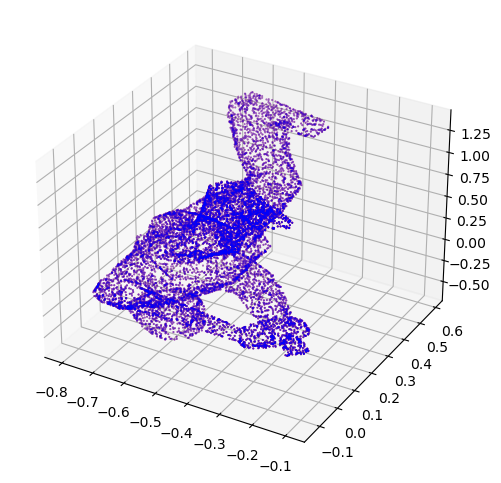

In [19]:
display2([(icp_trans[:3,:3]@src_cloud.T).T+icp_trans[:3,3], target_cloud])

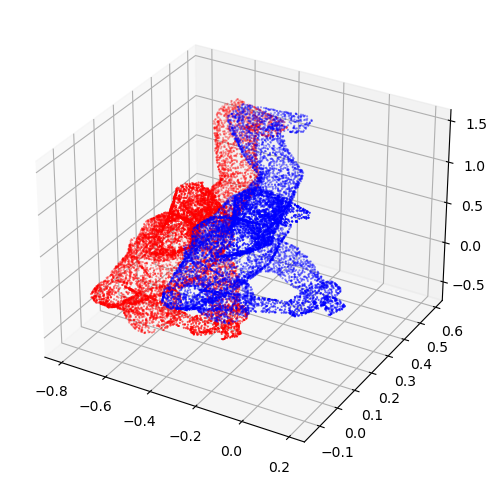

In [20]:
display2([(vcp_trans[:3,:3]@src_cloud.T).T+vcp_trans[:3,3], target_cloud])